In [ ]:
# structure of dataset IEMOCAP
'''
IEMOCAP_full_release/
|------ Documentation/
|      |----- corpus.dic
|      |----- Five_face_markers2.png
|      |----- HumaineInfo.txt
|      |----- phonemes.txt
|      |----- timeinfo.txt
|------ Session1/
|      |---- dialog/
|      |     |---- avi
|      |     |---- EmoEvaluation
|      |     |---- lab
|      |     |---- MOCAP_hand
|      |     |---- MOCAP_head
|      |     |---- MOCAP_rotated
|      |     |---- transcriptions
|      |     |---- wav
|      |---- sentences/
|------ Session2/
|------ Session3/
|------ Session4/
|------ Session5/
|------ README_backup.txt
|------ README.txt
'''


In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import sys
from tqdm import tqdm
import torch
import torchaudio
import torchaudio.transforms as T
from torchaudio.transforms import TimeStretch, Resample, Vol
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

## 1. Create file csv

In [4]:
def create_folder(dir_name):
    '''
    Create unexisted folder
    :param dir_name (str): directory to the folder needed to create
    
    return: none
    '''
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

### 1.1. Combine all audio files from folders sentences

In [5]:
def get_all_data(path):
    '''
    Create a folder including all files sentence audio
    :param path (str): directory to folder dataset
        
    return: none
    '''

    folder_dir = "./IEMOCAP_full_release/wav"
    create_folder(folder_dir)

    for x in range(5):
        ses_name = "Session" + str(x+1)
        path = "./IEMOCAP_full_release/" + ses_name + "/sentences/wav"    #directory to audio file
        for root, _, files in os.walk(path):
            for file_name in files:
                if file_name.endswith(".wav"):
                    file_wav = os.path.join(root,file_name)
                    shutil.copy(file_wav,folder_dir)
                
get_all_data("./IEMOCAP_full_release/")

In [6]:
path = "./IEMOCAP_full_release/wav/"
files = os.listdir(path)
num_files = len(files)
print("Number of file sentences wav: ",num_files)

Number of file sentences wav:  10039


### 1.2. Check mono/stereo, mono -> stereo

In [7]:
def stereo(path):
    list_files = os.listdir(path)
    for file in list_files:
        file = os.path.join(path,file)
        waveform, sr = torchaudio.load(file)
        num_channels = waveform.shape[0]
        if num_channels == 2:
            continue
        else:
            waveform_stereo = waveform.expand(2,-1)
            torchaudio.save(file,waveform_stereo,sr)
            
path = './IEMOCAP_full_release/wav/'
stereo(path)

In [8]:
waveform, sr = torchaudio.load("./IEMOCAP_full_release/wav/Ses01F_impro01_F009.wav")
waveform.shape

torch.Size([2, 65600])

### 1.3. Extract MFCCs

In [9]:
def extract_mfcc(path, shape):
    '''
    Extract MFCCs and save into 1 folder
    :param path (str): directory to folder dataset
    :param shape (list): list to store shape of mfccs
    
    return: shape of mfccs
    '''
    files = os.listdir(path)
    folder_dir = "./IEMOCAP_full_release/wav_mfcc"
    create_folder(folder_dir)

    for file in tqdm(files):                  # Initialize tqdm within the loop
        file_path = os.path.join(path, file)
        waveform, sample_rate = torchaudio.load(file_path)
        mfcc_transform = T.MFCC(sample_rate=sample_rate)(waveform)
        file_name = os.path.basename(file).rsplit('.', 1)[0] + '.pt'
        shape.append(mfcc_transform.shape)                 
        torch.save(mfcc_transform, os.path.join(folder_dir, file_name))

    return shape
    
shape = []
shape = extract_mfcc("./IEMOCAP_full_release/wav/", shape)

  0%|          | 0/10039 [00:00<?, ?it/s]

/Users/baoxuyennguyenle/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|██████████| 10039/10039 [00:36<00:00, 271.79it/s]


In [10]:
shape[0:3]
max(shape)

torch.Size([2, 40, 2732])

### 1.4. Extract Label

In [11]:
def extract_label(lines):
    '''
    Extract name and label from files .txt
    :param lines (str): Lines from files contained label
    
    return: : list of id and labels
    '''

    is_target = True
    id = ''
    label = ''
    labels = []
    for line in lines:
        
        if is_target == True:
            
            try:
                id = line.split('\t')[1].strip()
                label = line.split('\t')[2].strip()
                labels.append([id,label])
                is_target = False
                
            except IndexError as e:
                print("Encountered an IndexError:", e)
                
        else:
            if line == '\n':
                is_target = True
                
    return labels

In [12]:

def get_len(file_path):
    '''
    Get the duration of audios
    :param file_path (str): directory to folder audio
    
    return: list of length of audios
    '''
 
    waveform, sample_rate = torchaudio.load(file_path)
    audio_len = waveform.size(1)/sample_rate
    
    return audio_len
        

### 1.5. Write information to csv

In [13]:
def write_to_csv():
    '''
    Create dataframe including ID, label, length, path
    
    return: data
    '''
    
    labels = []
    data = []
    
    for x in range(5):
        sess_name = "Session" + str(x+1)
        files_dir = "./IEMOCAP_full_release/" + sess_name + "/dialog/EmoEvaluation"
        
        for _, folder, files in os.walk(files_dir):
            for fol in folder:
                folder_path = os.path.join(files_dir,fol)
                shutil.rmtree(folder_path)
                
            for file_name in files:
                full_path = os.path.join(files_dir,file_name)
                
                if file_name.endswith('.txt'):
                    with open(full_path,'r') as read_lines:
                        lines = read_lines.readlines()
                        lines = lines[2:]
                        labels = (extract_label(lines))
                        
                for label in labels:       
                    dir = "./IEMOCAP_full_release/wav/"
                    file_path = os.path.join(dir,label[0] + ".wav")     
                    len =  get_len(file_path)
                    data.append({
                        "ID": label[0],
                        "label": label[1],
                        "length": len,
                        "path": file_path
                })
            
    data = pd.DataFrame(data)

    return data
    

In [15]:
data = write_to_csv()
data.to_csv('processed_label_data.csv', index = False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSV file into a pandas dataframe
df = pd.read_csv('path/to/your/csv/file.csv')

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


# 2. EDA

### 2.1. Quick look

In [16]:
data = pd.read_csv("processed_label_data.csv")
data.head(10)

,ID,label,length,path
0,Ses01M_impro01_F000,ang,1.689938,./IEMOCAP_full_release/wav/Ses01M_impro01_F000...
1,Ses01M_impro01_F001,ang,2.050000,./IEMOCAP_full_release/wav/Ses01M_impro01_F001...
2,Ses01M_impro01_F002,xxx,3.769938,./IEMOCAP_full_release/wav/Ses01M_impro01_F002...
3,Ses01M_impro01_F003,xxx,3.949937,./IEMOCAP_full_release/wav/Ses01M_impro01_F003...
4,Ses01M_impro01_F004,fru,3.037500,./IEMOCAP_full_release/wav/Ses01M_impro01_F004...
5,Ses01M_impro01_F005,xxx,2.550000,./IEMOCAP_full_release/wav/Ses01M_impro01_F005...
6,Ses01M_impro01_F006,xxx,2.449937,./IEMOCAP_full_release/wav/Ses01M_impro01_F006...
7,Ses01M_impro01_F007,ang,3.419938,./IEMOCAP_full_release/wav/Ses01M_impro01_F007...
8,Ses01M_impro01_F008,ang,3.736000,./IEMOCAP_full_release/wav/Ses01M_impro01_F008...
9,Ses01M_impro01_F009,xxx,2.779937,./IEMOCAP_full_release/wav/Ses01M_impro01_F009...


In [17]:
data['ID'].describe()

count                   10039
unique                  10039
top       Ses01M_impro01_F000
freq                        1
Name: ID, dtype: object

In [18]:
data["label"].value_counts()

label
xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: count, dtype: int64

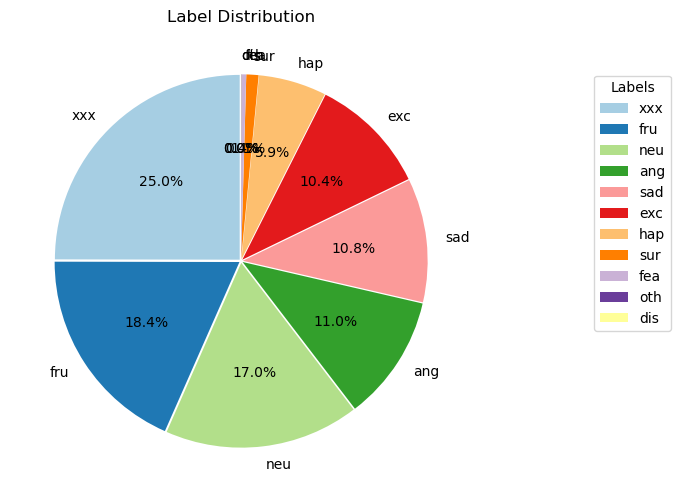

In [19]:
percentage = data['label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
explode = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
plt.pie(percentage, labels=percentage.index, explode=explode, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.25, 0, 0.5, 1.25))
plt.show()

- To serve the purpose of the problem and to simplify, the emotional labels can be merged into 3 main types: neutral, positive, negative
- The labels 'xxx' and 'other' will be removed to avoid confusion

### 2.2. Create new labels

In [20]:
data['label'] = data['label'].replace({'fru': 'neutral', 
                                       'neu': 'neutral',
                                        'exc': 'positive', 
                                        'hap': 'positive', 
                                        'sur': 'positive',
                                        'fea': 'negative', 
                                        'ang': 'negative', 
                                        'sad': 'negative', 
                                        'dis': 'negative'})

data = data[~data['label'].isin(['xxx', 'oth'])].reset_index(drop = True)
data.to_csv('./processed_label_data.csv')

In [21]:
data.head(10)

,ID,label,length,path
0,Ses01M_impro01_F000,negative,1.689938,./IEMOCAP_full_release/wav/Ses01M_impro01_F000...
1,Ses01M_impro01_F001,negative,2.050000,./IEMOCAP_full_release/wav/Ses01M_impro01_F001...
2,Ses01M_impro01_F004,neutral,3.037500,./IEMOCAP_full_release/wav/Ses01M_impro01_F004...
3,Ses01M_impro01_F007,negative,3.419938,./IEMOCAP_full_release/wav/Ses01M_impro01_F007...
4,Ses01M_impro01_F008,negative,3.736000,./IEMOCAP_full_release/wav/Ses01M_impro01_F008...
5,Ses01M_impro01_F010,neutral,2.019938,./IEMOCAP_full_release/wav/Ses01M_impro01_F010...
6,Ses01M_impro01_F011,negative,2.159937,./IEMOCAP_full_release/wav/Ses01M_impro01_F011...
7,Ses01M_impro01_F012,negative,1.925000,./IEMOCAP_full_release/wav/Ses01M_impro01_F012...
8,Ses01M_impro01_F015,neutral,6.009938,./IEMOCAP_full_release/wav/Ses01M_impro01_F015...
9,Ses01M_impro01_F019,negative,3.610000,./IEMOCAP_full_release/wav/Ses01M_impro01_F019...


In [22]:
data["ID"].describe()

count                    7529
unique                   7529
top       Ses01M_impro01_F000
freq                        1
Name: ID, dtype: object

In [23]:
data["label"].value_counts()

label
neutral     3557
negative    2229
positive    1743
Name: count, dtype: int64

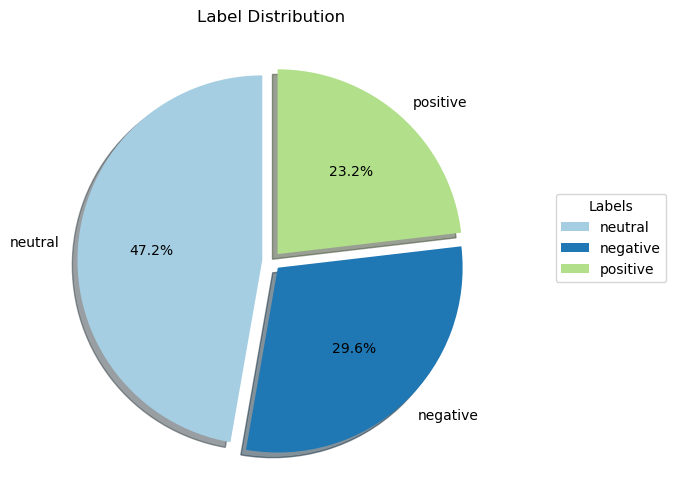

In [24]:
percentage = data['label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
explode = [0.05,0.05,0.05]
plt.pie(percentage, labels=percentage.index, explode=explode,shadow=True, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.1, 0, 0.5, 1.1))
plt.show()

After combining and spliting into 3 main labels: 'negative', 'positive' and 'neutral', there is a slight bias towards the 'neutral' label. 'neutral' counts for nearly half of data so we choose some data augmentation techniques for labels to achieve a more balanced dataset and be nearly similar to real data before beginning the training process.

In [25]:
# convert into onehot
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

label_tensor = torch.tensor(data['label_encoded'])
label_onehot = torch.nn.functional.one_hot(label_tensor)

data_onehot = pd.DataFrame(label_onehot, columns=[f'onehot_{i}' for i in range(label_onehot.shape[1])])
data = pd.concat([data, data_onehot], axis = 1)
data.head(10)

,ID,label,length,path,label_encoded,onehot_0,onehot_1,onehot_2
0,Ses01M_impro01_F000,negative,1.689938,./IEMOCAP_full_release/wav/Ses01M_impro01_F000...,0,1,0,0
1,Ses01M_impro01_F001,negative,2.050000,./IEMOCAP_full_release/wav/Ses01M_impro01_F001...,0,1,0,0
2,Ses01M_impro01_F004,neutral,3.037500,./IEMOCAP_full_release/wav/Ses01M_impro01_F004...,1,0,1,0
3,Ses01M_impro01_F007,negative,3.419938,./IEMOCAP_full_release/wav/Ses01M_impro01_F007...,0,1,0,0
4,Ses01M_impro01_F008,negative,3.736000,./IEMOCAP_full_release/wav/Ses01M_impro01_F008...,0,1,0,0
5,Ses01M_impro01_F010,neutral,2.019938,./IEMOCAP_full_release/wav/Ses01M_impro01_F010...,1,0,1,0
6,Ses01M_impro01_F011,negative,2.159937,./IEMOCAP_full_release/wav/Ses01M_impro01_F011...,0,1,0,0
7,Ses01M_impro01_F012,negative,1.925000,./IEMOCAP_full_release/wav/Ses01M_impro01_F012...,0,1,0,0
8,Ses01M_impro01_F015,neutral,6.009938,./IEMOCAP_full_release/wav/Ses01M_impro01_F015...,1,0,1,0
9,Ses01M_impro01_F019,negative,3.610000,./IEMOCAP_full_release/wav/Ses01M_impro01_F019...,0,1,0,0


### 2.3. Resize dataset

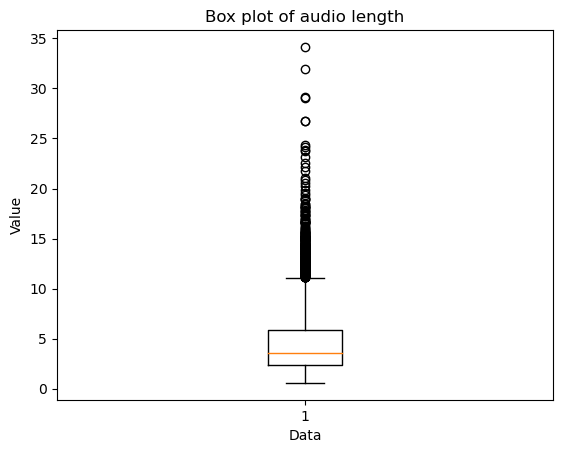

In [26]:
len = data["length"]
fig, ax = plt.subplots()

ax.boxplot(len)

ax.set_title('Box plot of audio length')
ax.set_xlabel('Data')
ax.set_ylabel('Value')
plt.show()

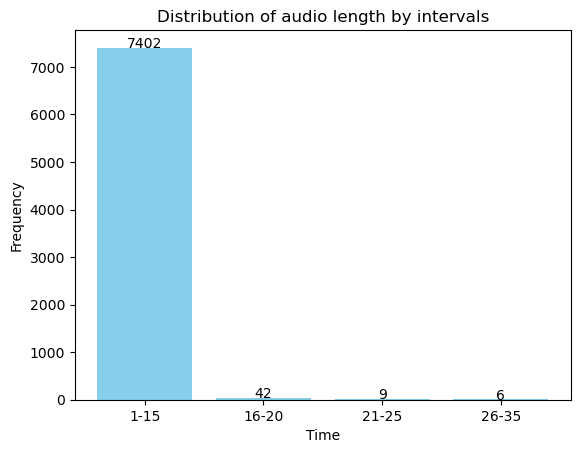

In [27]:
len = data["length"]
ranges = [(1, 15), (16, 20), (21, 25), (26, 35)]

# Create a list to store counts in each range
counts = [0] * 4

for num in len:
    for i, (start, end) in enumerate(ranges):
        if start <= num <= end:
            counts[i] += 1

plt.bar([f"{r[0]}-{r[1]}" for r in ranges], counts, color='skyblue')

for i, (start, end) in enumerate(ranges):
    plt.text(i,counts[i] + 1, str(counts[i]), ha = "center")

plt.xlabel("Time")   
plt.ylabel('Frequency')
plt.title('Distribution of audio length by intervals')
plt.show()

torch.Size([2, 27039])


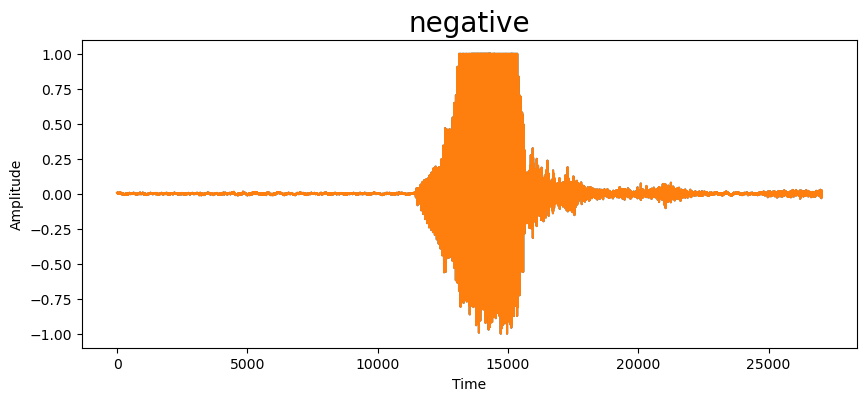

torch.Size([2, 96159])


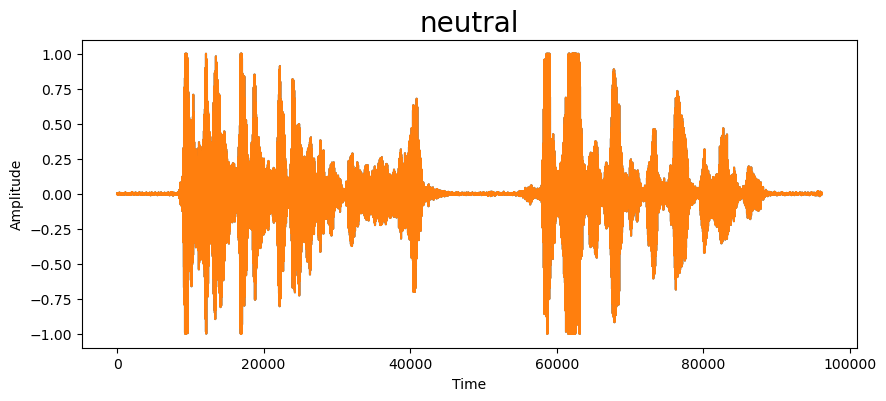

torch.Size([2, 70760])


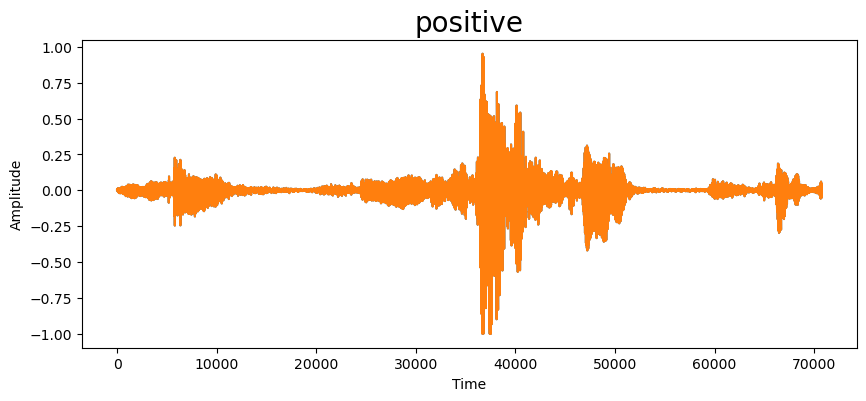

In [28]:
dir_index = [0, 8, 95]
for index in dir_index:
    dir_path = data['path'][index]
    waveform, sr = torchaudio.load(dir_path)
    print(waveform.shape)
    plt.figure(figsize=(10, 4))
    plt.title(data['label'][index], size=20)
    plt.plot(waveform.numpy().T)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

Negative emotion state is often accompanied by a significant sudden increase in the frequency of the sound.

Neutral emotion state usually produces sounds with moderate frequency, neither too high nor too low.

Positive emotion state often generates sounds with high and extended frequencies compared to the other states.

torch.Size([2, 40, 449])


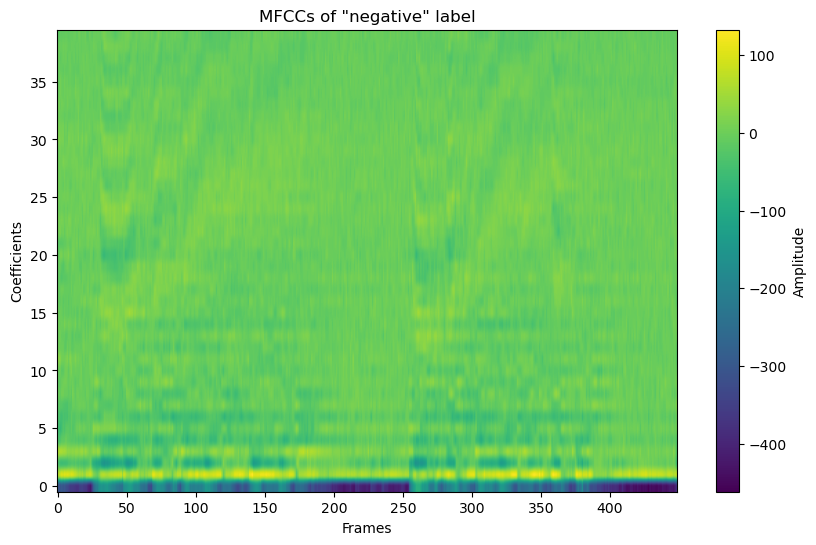

In [29]:
mfccs = torch.load("./IEMOCAP_full_release/wav_mfcc/Ses01F_impro01_F007.pt")
print(mfccs.shape)
plt.figure(figsize=(10, 6))
plt.imshow(mfccs[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title('MFCCs of "negative" label')
plt.xlabel('Frames')
plt.ylabel('Coefficients')
plt.colorbar(label='Amplitude')
plt.show()

torch.Size([2, 40, 220])


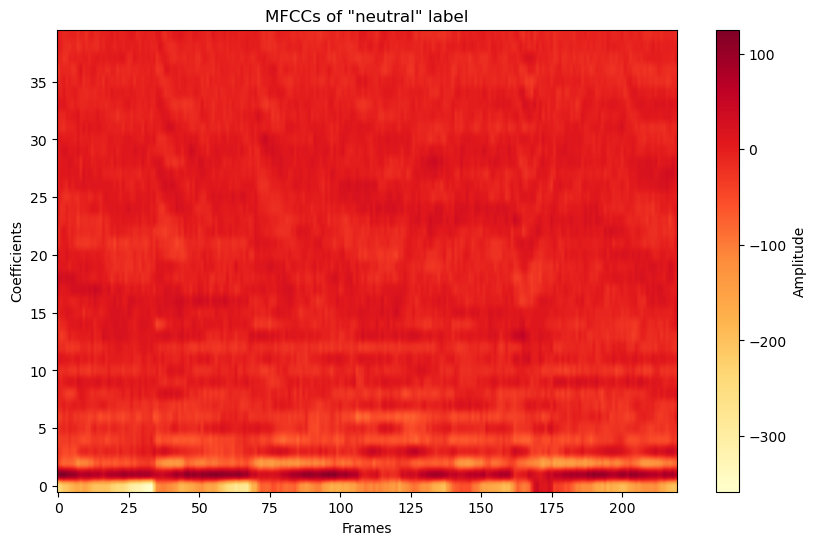

In [68]:
mfccs = torch.load("./IEMOCAP_full_release/wav_mfcc/Ses01F_impro01_F015.pt")

print(mfccs.shape)
plt.figure(figsize=(10, 6))
plt.imshow(mfccs[0].detach().numpy(), cmap='YlOrRd', origin='lower', aspect='auto')
plt.title('MFCCs of "neutral" label')
plt.xlabel('Frames')
plt.ylabel('Coefficients')
plt.colorbar(label='Amplitude')
plt.show()

torch.Size([2, 40, 156])
torch.Size([2, 40, 220])
torch.Size([2, 40, 233])


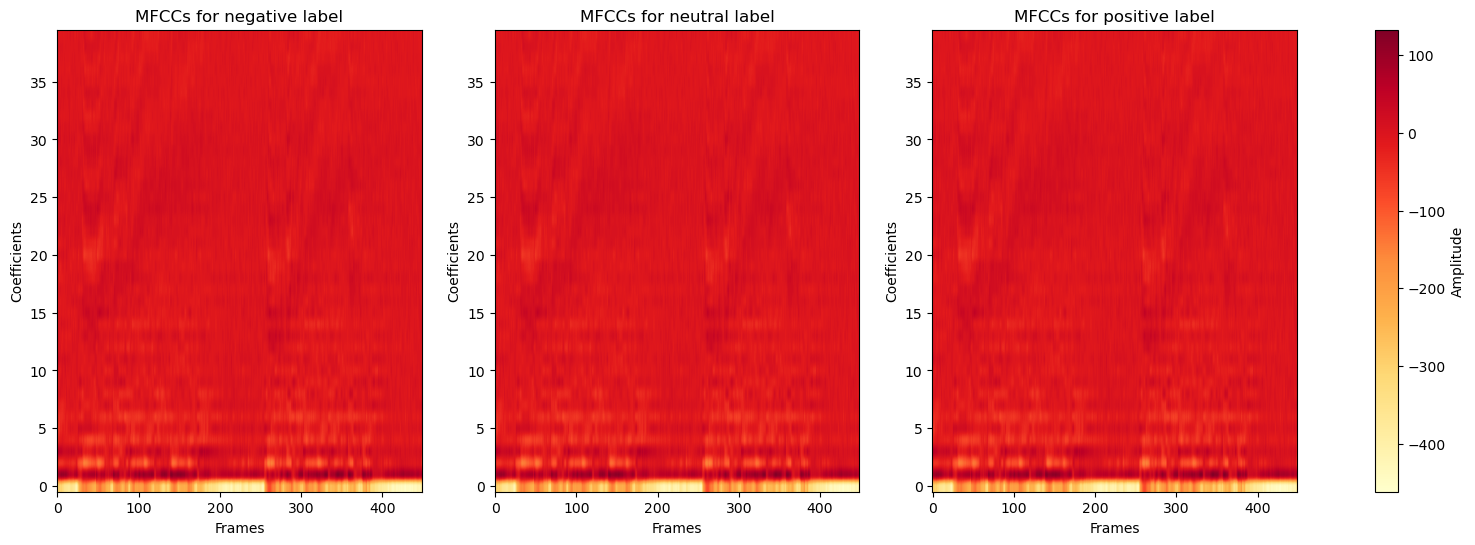

In [30]:
file_paths = ['./IEMOCAP_full_release/wav_mfcc/Ses01F_impro01_F000.pt', './IEMOCAP_full_release/wav_mfcc/Ses01F_impro01_F015.pt', './IEMOCAP_full_release/wav_mfcc/Ses01M_impro03_F017.pt']
labels = ['negative', 'neutral', 'positive']

fig, axes = plt.subplots(1,3, figsize = (20,6))
for i, file_path in enumerate(file_paths):
    mfcc = torch.load(file_path)
    print(mfcc.shape)
    axes[i].imshow(mfccs[0].detach().numpy(), cmap='YlOrRd', origin='lower', aspect='auto')
    axes[i].set_title(f'MFCCs for {labels[i]} label')
    axes[i].set_xlabel('Frames')
    axes[i].set_ylabel('Coefficients')
    axes[i].set_aspect('auto')

sm = plt.cm.ScalarMappable(cmap='YlOrRd')
sm.set_array(mfccs)
plt.colorbar(sm, ax=axes, label='Amplitude')  
plt.show()
    

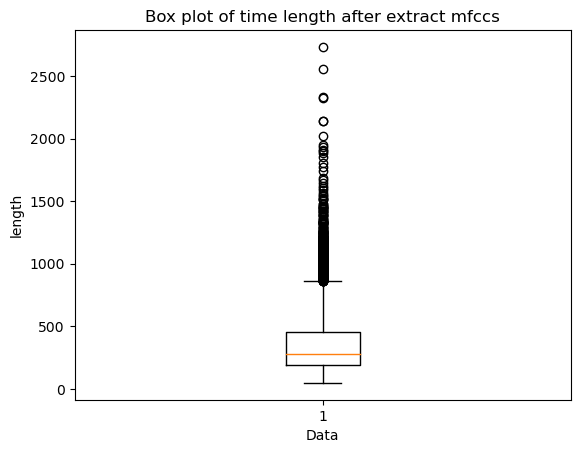

In [31]:
path = "./IEMOCAP_full_release/wav_mfcc/"
mfcc_dir_list = os.listdir(path)
time = []
for mfcc_dir in mfcc_dir_list:
    full_mfcc_dir = os.path.join(path,mfcc_dir)
    mfccs = torch.load(full_mfcc_dir)
    mfccs = mfccs.numpy() 
    time.append(mfccs.shape[2])    

fig, ax = plt.subplots()
ax.boxplot(time)

ax.set_title('Box plot of time length after extract mfccs')
ax.set_xlabel('Data')
ax.set_ylabel('length')
plt.show() 

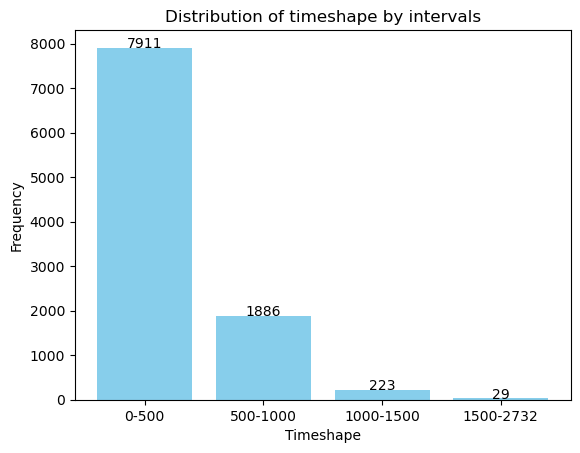

In [32]:
ranges = [(0,500), (500,1000), (1000, 1500), (1500, max(time))]

# Create a list to store counts in each range
counts = [0] * 4

for num in time:
    for i, (start, end) in enumerate(ranges):
        if start <= num <= end:
            counts[i] += 1

plt.bar([f"{r[0]}-{r[1]}" for r in ranges], counts, color='skyblue')

for i, (start, end) in enumerate(ranges):
    plt.text(i,counts[i] + 1, str(counts[i]), ha = "center")

plt.xlabel("Timeshape")   
plt.ylabel('Frequency')
plt.title('Distribution of timeshape by intervals')
plt.show()

The distribution of timeshape 0-900 frames counts for most of data, so we choose the the max timeshape is 900, remove all the outliner

In [33]:
def resize(path):
    list_files = os.listdir(path)
    for file_name in list_files: 
        file_path = os.path.join(path, file_name)
        sample = torch.load(file_path)
        pad_mfccs = torch.zeros(2, 40, 900)
        original_timeshape = sample.shape[2]
        
        if original_timeshape < 900:
            num_repeats = 900 // original_timeshape
            for i in range(num_repeats):
                start = i * original_timeshape
                end = min((i + 1) * original_timeshape, 900)
                pad_mfccs[:, :, start:end] = sample[:, :, :end - start]

        else:
            pad_mfccs = sample[:, :, :900]

        torch.save(pad_mfccs, file_path)
            
path = "./IEMOCAP_full_release/wav_mfcc/"
resize(path)

In [82]:
mfccs = torch.load('./IEMOCAP_full_release/wav_mfcc/Ses01F_impro01_F010.pt')
print(mfccs.shape)

torch.Size([2, 40, 900])


### 2.4. Add noise

### 2.5. Balance dataset

In [2]:
import torch
import numpy as np

def tensor_to_numpy():    
    list_ = ['data_valid','data_train','label_valid','label_train']
    file_save = 'features_labels.npy'
    with open(file_save, 'wb') as f:
        for name in list_:
            tensor = torch.load(name+'.pt')
            if len(tensor.shape) == 3:
                tensor = tensor.reshape((tensor.shape[0],1,40,tensor.shape[-1]))
            array = tensor.numpy()
            np.save(f, array)
            
tensor_to_numpy()

In [2]:
import pandas as pd
data = pd.read_csv("processed_shape_data.csv")
noise_data = pd.read_csv("processed_shape_noise_data.csv")

In [4]:
data['labels'] = data['labels'].replace({'fru': 'neutral', 
                                       'neu': 'neutral',
                                        'exc': 'positive', 
                                        'hap': 'positive', 
                                        'sur': 'positive',
                                        'fea': 'negative', 
                                        'ang': 'negative', 
                                        'sad': 'negative', 
                                        'dis': 'negative'})

data = data[~data['labels'].isin(['xxx', 'oth'])].reset_index(drop = True)
data.to_csv('./processed_shape_data.csv', index = False, index_label='index')

In [5]:
noise_data['labels'] = noise_data['labels'].replace({'fru': 'neutral', 
                                       'neu': 'neutral',
                                        'exc': 'positive', 
                                        'hap': 'positive', 
                                        'sur': 'positive',
                                        'fea': 'negative', 
                                        'ang': 'negative', 
                                        'sad': 'negative', 
                                        'dis': 'negative'})

noise_data = noise_data[~noise_data['labels'].isin(['xxx', 'oth'])].reset_index(drop = True)
noise_data.to_csv('./processed_shape_noise_data.csv',index = False, index_label='index')

In [6]:
add_noise_data = noise_data[noise_data["labels"].isin(["negative", 'positive'])]
data = pd.concat([data,add_noise_data],ignore_index = True)
data.to_csv('processed_shape_data.csv', index = False, index_label='index')

In [7]:
data['labels'].describe()

count        11501
unique           3
top       negative
freq          4458
Name: labels, dtype: object

In [43]:
data = pd.DataFrame(data)

In [8]:
count = 0
for i in range(len(data)):
    if data.loc[i,'labels'] == 'neutral':
        count += 1
        data.loc[i, 'path'] =  noise_data.loc[i, 'path']
    if count == 1333:
        break
    
data.to_csv("processed_shape_data.csv", index = False, index_label='index')

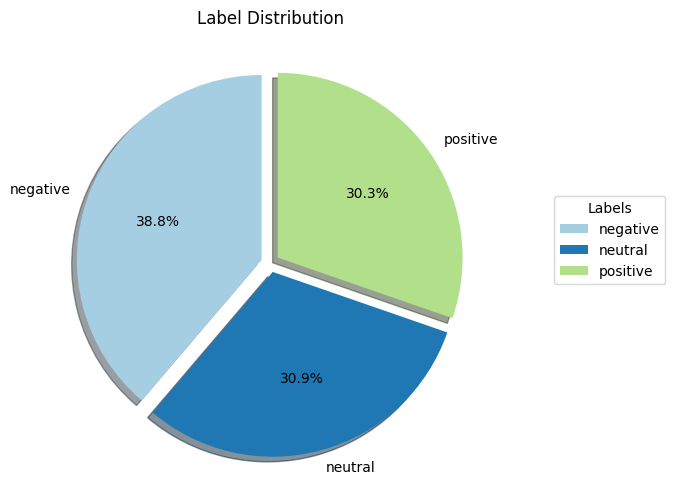

In [10]:
import matplotlib.pyplot as plt
percentage = data['labels'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
explode = [0.05,0.05,0.05]
plt.pie(percentage, labels=percentage.index, explode=explode,shadow=True, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.1, 0, 0.5, 1.1))
plt.show()